In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

# Finding ZeroPoint

In [4]:
dataPaths = natsorted(glob("../../Data/cometData01/" "*.fits"))

vReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/V/*"))[:-2]
rReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/R/*"))[:-2]
bReducedDataPaths = natsorted(glob("../../Python/DataProducts/ReducedImages/Day01/B/*"))[:-2]

In [11]:
vStackedStars = ctk.StackImages(vReducedDataPaths)
rStackedStars = ctk.StackImages(rReducedDataPaths)
bStackedStars = ctk.StackImages(bReducedDataPaths)

(array([474]),)


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
475,1701.066360750748,1639.3401806893323,0.8296898049864455,-0.09304915785163388,-0.11600518962111339,121,0.0,54439.714110680005,5724.372815370134,-9.394319776549464


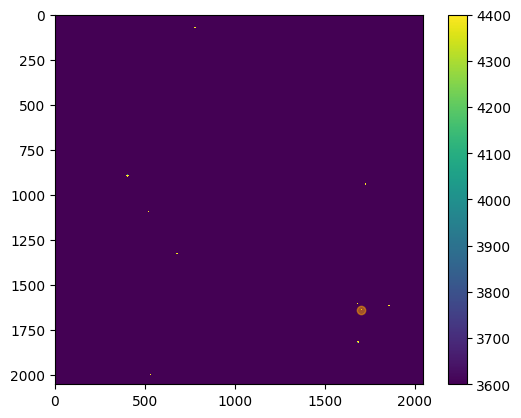

In [6]:
# Use to manually find star locations

sources = ctk.SearchStars(vStackedStars, showPlot=False)

plt.imshow(vStackedStars, vmin=4000, vmax=4000)
plt.colorbar()

# Finding stars
starCentre = (1700, 1650)
tolerance = 20
referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
print(referenceStarIndices)
plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")
sources[referenceStarIndices]

In [7]:
def DetermineStarZeroPoint(image, coordinatesList, calibratedMagnitudes, apertureRadius=30, tolerance=20, showPlot=False):
    
    sources = ctk.SearchStars(image, showPlot=False)

    zeroPoints = []

    # Finding stars
    for i, starCoords in enumerate(coordinatesList):
        starX = starCoords[0]
        starY = starCoords[1]

        referenceStarIndices = np.where((abs(sources["xcentroid"] - starCentre[0]) < tolerance) & (abs(sources["ycentroid"] - starCentre[1]) < tolerance))
        #print(referenceStarIndices)

        if showPlot:        
            plt.scatter(sources[referenceStarIndices]["xcentroid"], sources[referenceStarIndices]["ycentroid"], alpha=0.5, color="orange")

        #print(sources[referenceStarIndices])
        if len(sources[referenceStarIndices]) > 1:
            raise Exception("Too many stars found within tolerance for star: " + str(i))

        
        # Create aperture
        aperture = CircularAperture((sources[referenceStarIndices][0]["xcentroid"], sources[referenceStarIndices][0]["ycentroid"]), r=apertureRadius)

        # Find background
        background = Background2D(image, 50).background

        phot_table = aperture_photometry(vStackedStars - background, aperture)
        
        observedMagnitude = -2.5 * np.log10( phot_table["aperture_sum"] / (120 * len(vDataPaths)))

        
        zeroPoint = calibratedMagnitudes[i] - observedMagnitude
        zeroPoints.append(zeroPoint[0])

    return zeroPoints

In [12]:
coordinates = [(400, 890), (1720, 940), (1680, 1820), (1700, 1650)]
vCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19]
#rCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19] # NEEED TO ACTUALLY FIND R AND B MAGS
#bCalibratedMagnitudes = [11.84, 13.24, 13.15, 12.19]


vZeroPoint = np.mean(DetermineStarZeroPoint(vStackedStars, coordinates, vCalibratedMagnitudes, apertureRadius=30))
#rZeroPoint = np.mean(DetermineStarZeroPoint(rStackedStars, coordinates, rCalibratedMagnitudes, apertureRadius=30))
#bZeroPoint = np.mean(DetermineStarZeroPoint(bStackedStars, coordinates, bCalibratedMagnitudes, apertureRadius=30))

In [9]:
print(vZeroPoint, rZeroPoint, bZeroPoint)

20.122215277966063 20.122215277966063 20.122215277966063


# Aperture Curve

In [13]:
vImageStacked = ctk.GetImage("../DataProducts/vStacked.fits")

    xcentroid     
------------------
1702.1158658285538
  926.602471903746
481.92381154376307
498.41967851976494
 639.7709107397534
 657.9015915754992
 640.3769054529739
 975.7085802436018
 1639.747393451837
 1645.225653698835     ycentroid     
------------------
 885.5074478801033
 926.3905848708093
1038.0974218101692
1038.4151925551398
 1269.088926721027
1269.0818807266457
1274.8365124920117
1441.8378855803944
 1542.446000979453
1546.7423193373852


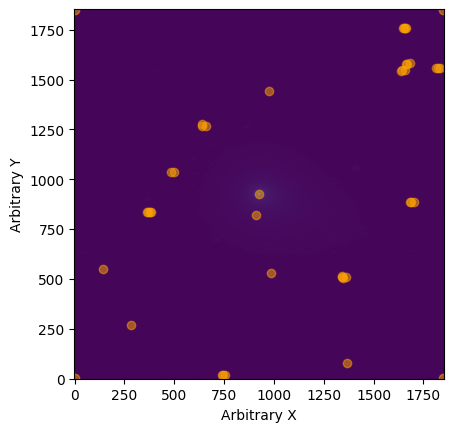

In [22]:
sources = ctk.SearchStars(vImageStacked, showPlot=True)

#for s in sources:
#    print(s)

comet = sources[20:30]
print(comet["xcentroid"], comet["ycentroid"])

comet = sources[21]

In [23]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

# Function to do this for range of apertures

In [24]:
def FindActivityCurve(image, comet, apertureRangeKm, zeroPoint, showPlot=False):
    
    activity = []
    cometDistance = 0.585 * 1.496e8 # au to km

    for aKm in apertureRangeKm:
        # Convert aperture range from km to pixel
        aPixel = (180 * 3600) / (0.6 * np.pi) * np.arctan2(aKm, cometDistance)

        # Create aperture
        aperture = CircularAperture((comet["xcentroid"], comet["ycentroid"]), r=aPixel)

        # Find background
        background = Background2D(image, 50).background

        if showPlot:
            # Plot
            fig, ax = plt.subplots()

            ax.imshow(image - background, vmin=0, vmax=80)
            apertureCircle = plt.Circle((comet["xcentroid"], comet["ycentroid"]), aPixel, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(image - background, aperture)
        
        # find magnitude within aperture
        mag = -2.5 * np.log10(phot_table["aperture_sum"] / 120) + zeroPoint

        wavelength = 0.5501 * u.um

        mag = mag * u.ABmag # absolute magnitude
        #print(mag)

        aper = aKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, mag, aper, eph)
        
        activity.append(afrho.value)
        #print(afrho)

    return [apertureRangeKm, activity]

In [26]:
apRange, activity = FindActivityCurve(vImageStacked, comet, np.linspace(500, 25000, 50), zeroPoint=np.mean(vZeroPoint), showPlot=False)

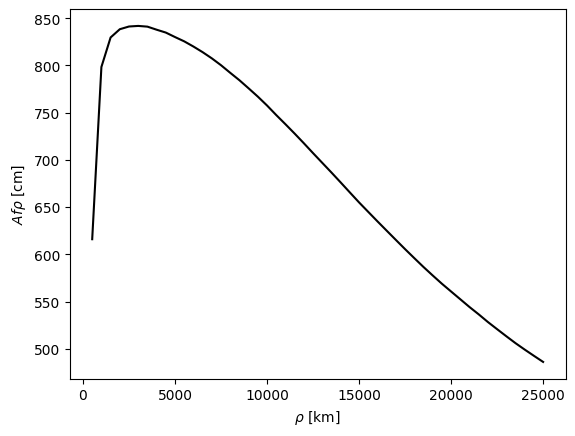

In [27]:
ctk.PlotAfrho(apRange, activity)